# New Plan

1. Split data into 4 seasons - process NOAA and CAISO data together.ipynb
2. Select a month in the season - I choose august bc no holidays hehe
3. Split season into weekdays and weekends/holidays
4. Output prediction for the whole season
5. Check it against the results from CAISO 

**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



# super peak 4-9pm
aka hour 16:00 - 21:00

In [132]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [133]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [134]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [135]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer

def prepareDf(df, cols_rearranged, baseLSTM_Directory, numDaysInMonth, location, superPeakBeg, superPeakEnd, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = 31 * 60 * day #num seconds in a month of AUGUST and JULY
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  

  df['superPeak'] = 0
  idx = df.between_time(superPeakBeg, superPeakEnd).index
  df.at[idx, 'superPeak'] = 1

  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [136]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size) 
    #############################################train and test #########################################################
    train_percent = 0.90
    validation_percent = 0.1

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation
    # X_train.shape, y_train.shape, X_val.shape, y_val.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

In [137]:
#purpose: selecting the best energy consumption model 
#input: iters = num iterations to find best model, df = dataframe, numEpochs = number of epochs for training model, baseLSTM_Directory = LSTM directory, location = place sf/sd/sac/etc.
#output: return a list of the best performing model for each weather var

def getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]

In [138]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption

def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    beg = 1 #
    end = window_size # first prediction starts from h1 -> h24
    newHour = window_size # the first predicted value
    while(i<howManyFutureHours): #for the next thirty hours
        if i == 0: #for the first new predicted value, using old weather data to predict new value 
            x_input = np.array(dataForPrediction.iloc[i:window_size, :])
            # print('x_input: ', x_input)
            x_input = x_input.reshape(1, window_size, numVarInputs)
            yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
            print(yhat[0])
            future_outputs.append(yhat[0][0])
            i=i+1
        else:# predicting new values
            # get past 23 hours data 
            past23Hours = dataForPrediction.iloc[beg:end,:]
            # print(future_outputs[newHour])
            predictedEnergy = future_outputs[i-1].item()
            dataForPrediction.at[newHour, -1:] = predictedEnergy #set the megawatts val from the prev predicted
            newHourData = dataForPrediction.iloc[newHour:newHour+1, :]
            newHourData = pd.concat([past23Hours, newHourData])
            oneData = np.array(newHourData)
            # print("{} hour input {}".format(1, oneData))
            oneData = oneData.reshape((1, window_size, numVarInputs)) #works
            yhat = bestEnergyConsumptionModel.predict(oneData, verbose=0)
            # print("{} hour output {}".format(i,yhat))
            future_outputs.append(yhat[0][0])
            i=i+1
            newHour+=1

    return future_outputs

In [139]:
def oneMonthRepresentation_august():
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/august/' 
  dates2019 = ['20190801','20190802','20190803','20190804','20190805','20190806','20190807','20190808','20190809','20190810','20190811','20190812',
               '20190813','20190814','20190815','20190816','20190817','20190818','20190819','20190820','20190821','20190822','20190823',
               '20190824','20190825','20190826','20190827','20190828','20190829','20190830','20190831']
  dates2020 = ['20200801','20200802','20200803','20200804','20200805','20200806','20200807','20200808','20200809','20200810','20200811','20200812',
               '20200813','20200814','20200815','20200816','20200817','20200818','20200819','20200820','20200821','20200822','20200823',
               '20200824','20200825','20200826','20200827','20200828','20200829','20200830','20200831']
  dates2021 = ['20210801','20210802','20210803','20210804','20210805','20210806','20210807','20210808','20210809','20210810','20210811','20210812',
               '20210813','20210814','20210815','20210816','20210817','20210818','20210819','20210820','20210821','20210822','20210823','20210824',
               '20210825','20210826','20210827','20210828','20210829','20210830','20210831']
  august = ['08-01','08-02','08-03','08-04','08-05','08-06','08-07','08-08','08-09','08-10','08-11','08-12','08-13','08-14','08-15','08-16',
          '08-17','08-18','08-19','08-20','08-21','08-22','08-23','08-24','08-25','08-26','08-27','08-28','08-29','08-30','08-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  result2019 = pd.DataFrame()
  result2020 = pd.DataFrame()
  result2021 = pd.DataFrame()
  for i in range(len(dates2019)):
    #2019
    read2019 = pathToData + beg + dates2019[i] + end
    df2019 = pd.read_csv(read2019)
    df2019.drop('date', axis=1, inplace=True)
    result2019 = pd.concat([result2019, df2019], axis=1)
    result2019.iloc[:1, :]
    result2019['mean'] = result2019.mean(axis=1)

    #2020
    read2020 = pathToData + beg + dates2020[i] + end
    df2020 = pd.read_csv(read2020)
    df2020.drop('date', axis=1, inplace=True)
    result2020 = pd.concat([result2020, df2020], axis=1)
    result2020.iloc[:1, :]
    result2020['mean'] = result2020.mean(axis=1)
    #2021
    read2021 = pathToData + beg + dates2021[i] + end
    df2021 = pd.read_csv(read2021)
    df2021.drop('date', axis=1, inplace=True)
    result2021 = pd.concat([result2021, df2021], axis=1)
    result2021.iloc[:1, :]
    result2021['mean'] = result2021.mean(axis=1)

  plt.plot(result2019['mean'], color = 'blue', label = '2019')
  plt.plot(result2020['mean'], color = 'red', label = '2020')
  plt.plot(result2021['mean'], color = 'green', label = '2021')

  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  plt.suptitle('August')
  plt.legend()
  plt.savefig(pathToSaveData+ 'augustAvg.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()
  rms2019_2020 = mean_squared_error(result2019['mean'], result2020['mean'], squared=False)
  rms2019_2021 = mean_squared_error(result2019['mean'], result2021['mean'], squared=False)
  rms2020_2021 = mean_squared_error(result2020['mean'], result2021['mean'], squared=False)
  avg3 = (rms2019_2020 + rms2019_2021 + rms2020_2021)/3
  print('Average RMSE between 2019-2020, 2019-2021, 2020-2021: ', avg3)

  averageAug = pd.concat([result2019['mean'], result2020['mean'], result2021['mean']], axis=1)
  finalRep = averageAug.mean(axis=1)
  return finalRep

In [140]:

def oneMonthRepresentation_july():
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/july/' 

  dates2019 = ['20190701','20190702','20190703','20190704','20190705','20190706','20190707','20190708','20190709','20190710',
               '20190711','20190712','20190713','20190714','20190715','20190716','20190717','20190718','20190719',
               '20190720','20190721','20190722','20190723','20190724','20190725','20190726','20190727','20190728','20190729','20190730','20190731']
  dates2020 = ['20200701','20200702','20200703','20200704','20200705','20200706','20200707','20200708','20200709','20200710',
               '20200711','20200712','20200713','20200714','20200715','20200716','20200717','20200718','20200719','20200720',
               '20200721','20200722','20200723','20200724','20200725','20200726','20200727','20200728','20200729','20200730','20200731']
  dates2021 = ['20210701','20210702','20210703','20210704','20210705','20210706','20210707','20210708','20210709','20210710','20210711',
               '20210712','20210713','20210714','20210715','20210716','20210717','20210718','20210719','20210720','20210721','20210722',
               '20210723','20210724','20210725','20210726','20210727','20210728','20210729','20210730','20210731']
  july = ['07-01','07-02','07-03','07-04','07-05','07-06','07-07','07-08','07-09','07-10','07-11','07-12','07-13','07-14','07-15',
          '07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26','07-27','07-28','07-29','07-30','07-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  result2019 = pd.DataFrame()
  result2020 = pd.DataFrame()
  result2021 = pd.DataFrame()
  for i in range(len(dates2019)):
    #2019
    read2019 = pathToData + beg + dates2019[i] + end
    df2019 = pd.read_csv(read2019)
    df2019.drop('date', axis=1, inplace=True)
    result2019 = pd.concat([result2019, df2019], axis=1)
    result2019.iloc[:1, :]
    result2019['mean'] = result2019.mean(axis=1)

    #2020
    read2020 = pathToData + beg + dates2020[i] + end
    df2020 = pd.read_csv(read2020)
    df2020.drop('date', axis=1, inplace=True)
    result2020 = pd.concat([result2020, df2020], axis=1)
    result2020.iloc[:1, :]
    result2020['mean'] = result2020.mean(axis=1)
    #2021
    read2021 = pathToData + beg + dates2021[i] + end
    df2021 = pd.read_csv(read2021)
    df2021.drop('date', axis=1, inplace=True)
    result2021 = pd.concat([result2021, df2021], axis=1)
    result2021.iloc[:1, :]
    result2021['mean'] = result2021.mean(axis=1)

  plt.plot(result2019['mean'], color = 'blue', label = '2019')
  plt.plot(result2020['mean'], color = 'red', label = '2020')
  plt.plot(result2021['mean'], color = 'green', label = '2021')

  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  plt.suptitle('July')
  plt.legend()
  plt.savefig(pathToSaveData+ 'julyAvg.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()
  rms2019_2020 = mean_squared_error(result2019['mean'], result2020['mean'], squared=False)
  rms2019_2021 = mean_squared_error(result2019['mean'], result2021['mean'], squared=False)
  rms2020_2021 = mean_squared_error(result2020['mean'], result2021['mean'], squared=False)
  avg3 = (rms2019_2020 + rms2019_2021 + rms2020_2021)/3
  print('Average RMSE between 2019-2020, 2019-2021, 2020-2021: ', avg3)

  averageJuly= pd.concat([result2019['mean'], result2020['mean'], result2021['mean']], axis=1)
  finalRep = averageJuly.mean(axis=1)
  return finalRep

# Run

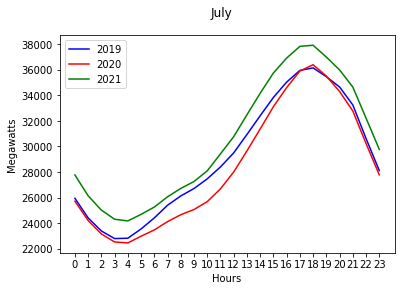

Average RMSE between 2019-2020, 2019-2021, 2020-2021:  1496.465666014826


In [141]:
julyRep = oneMonthRepresentation_july()

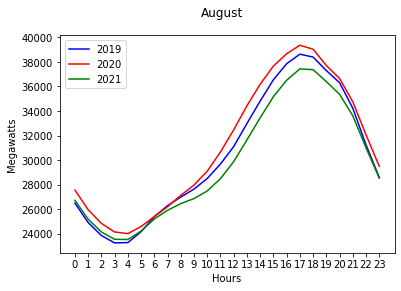

Average RMSE between 2019-2020, 2019-2021, 2020-2021:  1080.2637245761057


In [142]:
augustRep = oneMonthRepresentation_august()

In [145]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/Years_Average/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

fileRead = pathToData + dataFile[0]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
dfOriginal = pd.read_csv(fileRead)

#universal variables set
howManyFutureHours = 24
window_size = 24
numEpochs = 30
iters = 1

#july variables
beg_july = 4344
end_july = 5088
numDaysInMonth_july = 31

#august variables
beg_august = 5088
end_august = 5832
numDaysInMonth_august = 31

#prepareDf variables
superPeakBeg ='16:00' 
superPeakEnd = '20:00'

baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/'
location = '_SAC'
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL
# bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, cols_rearranged, columns, df, currentDirectory, location)


SAC-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/Years_Average/SAC-yearAvg-NOAA-and-Megawatts.csv


1247
Epoch 1/30
33/36 [==========================>...] - ETA: 0s - loss: 0.2888 - root_mean_squared_error: 0.5374

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 9s 197ms/step - loss: 0.2788 - root_mean_squared_error: 0.5280 - val_loss: 0.1624 - val_root_mean_squared_error: 0.4029
Epoch 2/30
36/36 [==============================] - ETA: 0s - loss: 0.0844 - root_mean_squared_error: 0.2905

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 6s 168ms/step - loss: 0.0844 - root_mean_squared_error: 0.2905 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2190
Epoch 3/30
35/36 [============================>.] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.1888

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 139ms/step - loss: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 4/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0215 - root_mean_squared_error: 0.1467

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 148ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 5/30
36/36 [==============================] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.1174

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 136ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 6/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0963

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 148ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 7/30
35/36 [============================>.] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0841

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 143ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 8/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0778

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 138ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 9/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0731

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 150ms/step - loss: 0.0053 - root_mean_squared_error: 0.0727 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803
Epoch 10/30
35/36 [============================>.] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0693

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 134ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 11/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 12/30
32/36 [=========================>....] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0664

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 147ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 13/30
36/36 [==============================] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0640

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 135ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762
Epoch 14/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 15/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0621

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 152ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 16/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0738
Epoch 17/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 18/30
36/36 [==============================] - 0s 14ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 19/30
36/36 [==============================] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0564

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 143ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0710
Epoch 20/30
36/36 [==============================] - 0s 13ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 21/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0541

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 135ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 22/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0524

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 150ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 23/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0519

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 145ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 24/30
32/36 [=========================>....] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0499

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 137ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 25/30
36/36 [==============================] - 1s 16ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 26/30
34/36 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0468

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 151ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 27/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 135ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 28/30
36/36 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0448

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 148ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 29/30
33/36 [==========================>...] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 146ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 30/30
35/36 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0428

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/model_SAC/assets


36/36 [==============================] - 5s 136ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
RMSE value:  0.040948030687288604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_SAC/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/Best_SAC/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


[0.2345061]
----------------------------FINAL, DONE;----------------------------
rmse value:  5210.281648119023


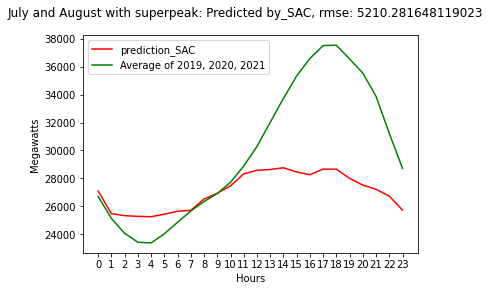

In [146]:
df.columns[1:-1]
cols_rearranged = list(df.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('superPeak')
cols_rearranged.append('AvgMegawatts2019-2020-2021')

df_august = prepareDf(df, cols_rearranged, baseLSTM_Directory, numDaysInMonth_august, location, superPeakBeg, superPeakEnd, beg_august, end_august)
df_july = prepareDf(df, cols_rearranged, baseLSTM_Directory,  numDaysInMonth_july, location, superPeakBeg, superPeakEnd, beg_july, end_july,)
df_august = df_august[df_august.is_weekend == 0] # only keeping weekday data
df_august.drop('is_weekend', axis = 1, inplace =True)
df_july.drop('is_weekend', axis = 1, inplace = True)
df_august, allScalers_august = scaleAllData(df_august)
df_july, allScalers_july = scaleAllData(df_july)
df = pd.concat([df_july, df_august])

# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers

bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")

########################################## GET WEATHER DATA FOR FUTURE PREDICTION #######################################################
lastDay_input = df.iloc[len(df) - (window_size*2):(len(df) - window_size),:] # second to last day

# # ########################################## FUTURE PREDICTION #######################################################

numVarInputs = len(lastDay_input.columns)

# print('num var inputs: ', numVarInputs)
# I need ground truth weather data 
weatherData = df.iloc[len(df)- (window_size):, :-1] 
weatherData['AvgMegawatts2019-2020-2021'] = 0 #24->47 is for "future" day; exclude megawatts data

dataForPrediction = pd.concat([lastDay_input, weatherData])

lst_output = futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs)

# # ########################################### check output #######################################################
# scaler_filename = baseLSTM_Directory + 'Best'+ location+ '/Scalers' + location+'/AvgMegawatts2019-2020-2021.save'

# megawattsScaler = joblib.load(scaler_filename)
megawattsScaler = allScalers_august[len(allScalers_august)-1]

predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
predicted24Hours = pd.DataFrame(predictedVals)

july_aug = pd.concat([julyRep, augustRep], axis=1)
july_aug['mean'] = july_aug.mean(axis=1)

print("----------------------------FINAL, DONE;----------------------------")
rmse = mean_squared_error(augustRep, predicted24Hours, squared=False)
print('rmse value: ', rmse)

plt.plot(predicted24Hours, color = 'red', label = 'prediction'+location)
plt.plot(july_aug['mean'], color = 'green', label = 'Average of 2019, 2020, 2021')
xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('July and August with superpeak: Predicted by'+location+', rmse: ' + str(rmse))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/LSTM-SeasonsAGAIN/byMonth/'
plt.savefig(pathToSaveData+ 'july and august Avg'+location+'.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

In [ ]:
# with time factored in:
# 6249
# 4869
# 6023

In [ ]:
# predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
# predicted24Hours = pd.DataFrame(predictedVals)
# predicted24Hours
#278873, 24722

In [ ]:
# dfOriginal

In [ ]:
# res = megawattsScaler.fit_transform(np.array(dfOriginal['AvgMegawatts2019-2020-2021'].values.reshape(-1, 1)))
# predictedVals = megawattsScaler.inverse_transform(np.array(res).reshape(-1,1))
# predictedVals

In [ ]:
# df